In [418]:
import math
from botorch.utils import t_batch_mode_transform
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import AcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize

#kernels
from gpytorch.kernels import RBFKernel, MaternKernel, LinearKernel, ScaleKernel

problem setting

penicillin

In [419]:
from botorch.test_functions.multi_objective import Penicillin
from botorch.utils.sampling import draw_sobol_samples
test_f = Penicillin(negate = True)
bounds = bounds = torch.tensor([[60,10,293,10,0.01,600,5],[120, 18, 303, 18, 0.1, 700, 6.5]], dtype= torch.float64)
def generate_initial_data(n):
    # generate training data
    train_x = draw_sobol_samples(bounds=bounds, n=n, q=1).squeeze(1)
    train_obj = test_f(train_x)
    return train_x, train_obj

acquisition

In [420]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(((u_t / self.theta) ** m), dim=-1)[0]  # b

        return scalarized_ut


Auxiliary Acq

In [421]:
class AuxiliaryAcq(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        An auxiliary acquisition defined in Algo.2

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(MCAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform()
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        #print(posterior.mean.shape)
        means = posterior.mean  # b x q x o
        std_devs = posterior.variance.sqrt()  # b x q x o
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x qx o
        #print('233', u_t.shape)

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.min(u_t, dim=-1)[0], dim=-1)[0]  # b
        return scalarized_ut


constraints

In [422]:
import torch
from typing import List, Tuple, Callable

def create_ucb_constraints_NSGAII(inp, model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """
    
    def constraint(X):
        """
        Evaluates all constraints for a batch of design points.

        Args:
            X (torch.Tensor): A tensor of shape [q, d] (where `d` is the dimension of the input space and `q` can be 1 or more 
                              representing different design points).

        Returns:
            torch.Tensor: A tensor of shape [q, m] (where `m` is the number of output dimensions) containing the evaluated 
                          constraints.
        """
        # Compute posterior at X
        X = X.unsqueeze(0)
        posterior = model.posterior(X)
        mean = posterior.mean
        variance = posterior.variance
        ucb = mean + beta * variance.sqrt()  # Compute the UCB

        # Evaluate all constraints and return the difference from thresholds
        return  ucb - thresholds

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [constraint(inp)[:, i] for i in range(thresholds.size(0))]

    return constraints


In [423]:
torch.rand(1,7).shape

torch.Size([1, 7])

In [424]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

BO loop

take thresholds to be: 10, -60, -350

approximated maximum HV(with 70 points): ~11000

kernel picking

In [425]:
from Customized_Kernels import Customized_RBF, Customized_Matern
from metrics import HV, violation
base = MaternKernel()
covar_module = ScaleKernel(
base_kernel=base,
)

In [426]:
import warnings
from platypus import NSGAII, Problem, Real, nondominated

warnings.filterwarnings('ignore')
import time
c = 0
thresholds = torch.tensor([10, -60, -350], dtype= torch.float64)
print('0'*50)
random_seeds = [83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563,
26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052]
declared = False
for seed in [1]:
    torch.manual_seed(seed)
    train_X, train_Y = generate_initial_data(64)
    train_X = normalize(train_X, bounds)
    '''feasible_ind = (violation(train_Y, thresholds) == 0)
    train_X = train_X[feasible_ind,:]
    train_Y = train_Y[feasible_ind,:]'''
    Hpv = []
    Acq = []
    NUM_ITER = 200
    for batch in range(NUM_ITER):
        t0 = time.monotonic()
        model_list = []
        m = 3
        for i in range(m):
            current_model = SingleTaskGP(covar_module= covar_module, train_X= train_X, train_Y= train_Y[:, i].unsqueeze(-1), outcome_transform= Standardize(m = 1), train_Yvar= torch.zeros((train_X.shape[0],1)) + 0.05**2)
            model_list.append(current_model)
        model = ModelListGP(*model_list)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        #t1 = time.monotonic()
        #sample theta from distribution
        theta = get_random_sample_on_n_sphere(m,1).abs()
        beta = 1*0.2 * math.log((batch+1)*4)
        beta_const = 1*0.2 * math.log((batch+1)*4)
        #optimize constraint function with NSGAII algorithm
        def acq_objective(X:list):
            X= torch.tensor([X])
            with torch.no_grad():
                posterior = model.posterior(X)
                mean = posterior.mean
                variance = posterior.variance
                ucb_obj = mean + beta * variance.sqrt() -thresholds
                ucb_const = mean + beta_const * variance.sqrt() - thresholds
                acq = torch.min(torch.max(torch.zeros_like(ucb_obj), ucb_obj / theta) ** m, dim=-1)[0].cpu().tolist()
                ucb_const = ucb_const.cpu().numpy().squeeze(0).tolist()
                return acq, ucb_const
        prob = Problem(7, 1, 3)
        prob.types[:] = [Real(0,1)]*7
        prob.constraints[:] = '>=0'
        prob.function = acq_objective
        prob.directions[:] = Problem.MAXIMIZE
        algo = NSGAII(problem=prob, population_size= 1 )
        algo.run(1000)
        candidate = torch.tensor([list(sol.variables) for sol in algo.result])
        #t3 = time.monotonic()
        #update data
        train_X = torch.cat([train_X, candidate],dim=0)
        train_Y = torch.cat([train_Y, test_f(unnormalize(candidate, bounds= bounds))], dim = 0)
        hv = HV(Y = train_Y, ref = thresholds)
        acq_scalar = algo.result[0].objectives
        Hpv.append(hv)
        Acq.append(acq_scalar)
        print(f'round{batch+1}: Hpv:{hv}, Acq:{acq_scalar}')
    if not declared:
        c+=1
        #torch.save(torch.tensor(Hpv), f'hv_peni_{c}.pt')
        #torch.save(torch.tensor(Acq), f'acq_peni_{c}.pt')
        #torch.save(train_Y, f'obj_peni_{c}.pt')
        print('o', end='')
    else:
        print('*', end='')
    declared = False

00000000000000000000000000000000000000000000000000


round1: Hpv:3464.960466369801, Acq:[5544.855943786512]
round2: Hpv:3553.055359379975, Acq:[49481.25123401469]
round3: Hpv:3553.055359379975, Acq:[3192.835900845861]
round4: Hpv:3553.055359379975, Acq:[10250.37351315304]
round5: Hpv:3553.055359379975, Acq:[4778.106187098005]
round6: Hpv:3553.055359379975, Acq:[681.8047246818721]
round7: Hpv:3553.055359379975, Acq:[307.4661573398042]
round8: Hpv:3624.563366604626, Acq:[13505.44221268877]
round9: Hpv:3624.563366604626, Acq:[157.92347245577002]
round10: Hpv:3624.563366604626, Acq:[1109.065935308311]
round11: Hpv:3631.277091771366, Acq:[280.8183299904768]
round12: Hpv:3631.277091771366, Acq:[439.0959273612573]
round13: Hpv:3631.277091771366, Acq:[127.68614324674229]
round14: Hpv:3631.277091771366, Acq:[7930.087353684]
round15: Hpv:3631.277091771366, Acq:[18363.144208456775]
round16: Hpv:3631.277091771366, Acq:[254.11933114746066]
round17: Hpv:3631.277091771366, Acq:[318.14807269767664]
round18: Hpv:3631.277091771366, Acq:[426.957297388103]


KeyboardInterrupt: 

In [440]:


prob = Problem(7, 1, 3)
prob.types[:] = [Real(0,1)]*7
prob.constraints[:] = '>=0'
prob.function = acq_objective
prob.directions[:] = Problem.MAXIMIZE
algo = NSGAII(problem=prob, population_size= 1 )
algo.run(500)
candidate_2 = torch.tensor([list(sol.variables) for sol in algo.result])
print(candidate_2, torch.tensor([list(sol.objectives) for sol in algo.result]))

tensor([[0.5645, 0.0357, 0.2837, 0.7255, 0.8411, 0.9598, 0.4225]]) tensor([[3.7137]])


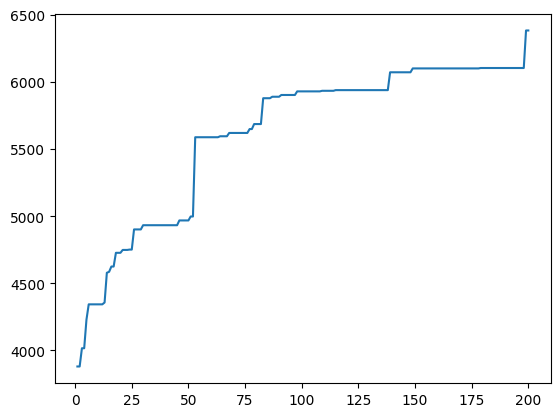

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(Hpv)+1), Hpv)

In [ ]:

obj_1 = train_Y[16:, :2]
hv_1 = Hpv
#acq_1 = torch.load(f'acq_toy_{e}.pt')
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.tricontourf(obj_1[:,0], obj_1[:,1], hv_1)
#ax[1].tricontourf(obj_1[:,0], obj_1[:,1], acq_1)
a = 10
b = -60
n = range(70)
for i, txt in enumerate(n):
    ax.annotate(txt, (obj_1[:,0][i], obj_1[:,1][i]), fontsize = 10, c= 'red', alpha = 0.5)
for i in range(1):
    ax.plot([a,20], [b,b], c = 'pink')
    ax.plot([a,a], [b,-2], c = 'pink')
    ax.scatter(obj_1[:,0], obj_1[:,1], c = 'red', s = 0.5)
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
ax.set_title('HV-objective')


NameError: name 'plt' is not defined

In [ ]:
obj_1 = train_Y[16:, (0,2)]
hv_1 = Hpv
#acq_1 = torch.load(f'acq_toy_{e}.pt')
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.tricontourf(obj_1[:,0], obj_1[:,1], hv_1)
#ax[1].tricontourf(obj_1[:,0], obj_1[:,1], acq_1)
a = 10
b = -350
n = range(70)
for i, txt in enumerate(n):
    ax.annotate(txt, (obj_1[:,0][i], obj_1[:,1][i]), fontsize = 10, c= 'red', alpha = 0.5)
for i in range(1):
    ax.plot([a,20], [b,b], c = 'pink')
    ax.plot([a,a], [b,-200], c = 'pink')
    ax.scatter(obj_1[:,0], obj_1[:,1], c = 'red', s = 0.5)
    ax.set_xlabel('y1')
    ax.set_ylabel('y3')
ax.set_title('HV-objective')

In [ ]:
obj_1 = train_Y[16:, (1,2)]
hv_1 = Hpv
#acq_1 = torch.load(f'acq_toy_{e}.pt')
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.tricontourf(obj_1[:,0], obj_1[:,1], hv_1)
#ax[1].tricontourf(obj_1[:,0], obj_1[:,1], acq_1)
a = -60
b = -350
n = range(70)
for i, txt in enumerate(n):
    ax.annotate(txt, (obj_1[:,0][i], obj_1[:,1][i]), fontsize = 10, c= 'red', alpha = 0.5)
for i in range(1):
    ax.plot([a,-20], [b,b], c = 'pink')
    ax.plot([a,a], [b,-200], c = 'pink')
    ax.scatter(obj_1[:,0], obj_1[:,1], c = 'red', s = 0.5)
    ax.set_xlabel('y2')
    ax.set_ylabel('y3')
ax.set_title('HV-objective')

In [ ]:
dom , _ = generate_initial_data(100)
posterior = model.posterior(dom)
mean = posterior.mean
std = posterior.variance.sqrt()

In [ ]:
plt.plot()